# EECE5644 - HW5

#### Important imports


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from mpl_toolkits.axes_grid1 import make_axes_locatable
import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.models import Sequential
from keras.layers import Dense
np.set_printoptions(suppress=True)
from tensorflow.keras.optimizers import SGD
from sklearn.svm import SVC

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

#Question-1

####Helper Functions

In [29]:
def gen_data(num_samples, priors):
    noise = np.random.multivariate_normal(noise_mu, noise_sigma, num_samples).T

    thetas = np.random.uniform(-np.pi, np.pi, num_samples)
    sample_data = np.random.uniform(0.0, 1.0, num_samples)
    num_cls1 = np.sum((sample_data <= priors[0]).astype('int'))
    num_cls2 = num_samples - num_cls1

    cos_thetas = np.cos(thetas).reshape((-1, 1))
    sine_thetas = np.sin(thetas).reshape((-1, 1))
    vecs = np.hstack((cos_thetas, sine_thetas)).T

    data_cls1 = r[0] * vecs[:, :num_cls1] + noise[:, :num_cls1]
    data_cls2 = r[1] * vecs[:, num_cls1:] + noise[:, num_cls1:]
    label_cls1 = np.zeros((1, num_cls1), dtype='int')
    label_cls2 = np.ones((1, num_cls2), dtype='int')

    data_wt_cls1 = np.vstack((data_cls1, label_cls1))
    data_wt_cls2 = np.vstack((data_cls2, label_cls2))

    return np.hstack((data_wt_cls1, data_wt_cls2))


def split_data(data_wt_labels, label_ids):
    samples = []
    for label_id in label_ids:
        class_ids = np.where(data_wt_labels[-1,:]==label_id)[0]
        cls_samples = data_wt_labels[:,class_ids]
        samples.append(cls_samples)
    
    return samples


def plot_data(data_wt_labels, label_ids, name):
    fig = plt.figure()
    ax = fig.add_subplot()
    samples = split_data(data_wt_labels, label_ids)
    colors = ['red', 'blue', 'green', 'brown']

    for label_id, sample in enumerate(samples):
        ax.scatter(sample[0, :], sample[1, :], s=5, color = colors[label_id], label = 'class ' + str(label_id), marker='*')
    
    ax.set_title(name + ' data distribution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.legend()
    plt.show()


def get_model(first_num_nodes, num_labels=1):
    sgd = SGD(lr=0.05, momentum=0.9)
    model = Sequential()

    fc1_act = Dense(units = first_num_nodes, kernel_initializer = 'random_uniform', activation = 'relu')
    model.add(fc1_act)
    fc2_act = Dense(units = num_labels, kernel_initializer = 'random_uniform', activation = 'sigmoid')
    model.add(fc2_act)

    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics = ['accuracy'])
    return model


def get_hp_values(num):
    hp_values = np.meshgrid(np.geomspace(0.05, 40, num), np.geomspace(0.05, 40, num))
    hp_values[0] = hp_values[0].reshape(num*num)
    hp_values[1] = hp_values[1].reshape(num*num)
    hp_values = np.vstack((hp_values[0], hp_values[1])).T

    return hp_values


def SVC_hyperparams(data_wt_labels, kfold):
    num_samples = data_wt_labels.shape[1]
    data_wt_labels = data_wt_labels[:, np.random.permutation(data_wt_labels.shape[1])]

    data = data_wt_labels[:2,:].T
    labels = data_wt_labels[2,:].T

    num = 20
    hp_values = get_hp_values(num)

    hp_lst = []
    for C, kernel_width in hp_values:
        err_lst = []
        acc_lst = []
        skf = StratifiedKFold(n_splits=kfold, shuffle=False) 

        for(val_idx, (train, val)) in enumerate(skf.split(data, labels)):
            train_data = data[train]
            train_labels = labels[train]
            val_data = data[val]
            val_labels = labels[val]
            gamma = 1/(2*kernel_width**2)
            model = SVC(C=C, kernel='rbf', gamma=gamma) #Radial Basis Kernel = rbf in sklearn
            model.fit(train_data, train_labels)
            predictions = model.predict(val_data)
            acc = np.sum(((predictions - val_labels) == 0).astype('int'))/val_data.shape[0]
            err = 1 - acc
            err_lst.append(err)
            acc_lst.append(acc)

        mean_err = np.mean(np.array(err_lst))
        std_err = np.std(np.array(err_lst))
        mean_acc = np.mean(np.array(acc_lst))
        hp_lst.append(mean_acc)

    hp_lst = np.array(hp_lst)
    desired_hp = hp_values[np.argmax(hp_lst)]
    print('desired_hp: ',desired_hp)
    max_acc = hp_lst[np.argmax(hp_lst)]
    min_err = 1 - max_acc
    print('Maximum Accuracy:',max_acc)
    grid = np.meshgrid(np.geomspace(0.05, 40, num), np.geomspace(0.05, 40, num))
    hp_lst_reshape = np.reshape(hp_lst, (num, num))
    fig, ax = plt.subplots()
    c = ax.pcolormesh(grid[0], grid[1], hp_lst_reshape, cmap='RdBu')
    ax.set_title("SVM K-Fold Hyperparameter Validation Performance")
    ax.set_xlabel("Overlap penalty weight")
    ax.set_ylabel("Gaussian kernel width")
    ax.axis([grid[0].min(), grid[0].max(), grid[1].min(), grid[1].max()])
    fig.colorbar(c, ax=ax, boundaries=np.linspace(0,1,10))
    ax.grid(True, color="crimson", lw=2)
    plt.show()
    plt.savefig("SVM_hp.png")
    plt.close()
    return desired_hp


def MLP_hyperparams(data_wt_labels, kfold, num_perc_lst):
    num_samples = data_wt_labels.shape[1] 
    data_wt_labels = data_wt_labels[:, np.random.permutation(data_wt_labels.shape[1])]
    data = data_wt_labels[:2,:].T 
    labels = data_wt_labels[2,:].T

    perc_lst = []
    perc_lst_acc = []
    for num_perc in num_perc_lst:
        err_lst = []
        acc_lst = []
        skf = StratifiedKFold(n_splits=kfold, shuffle=False)

        for(val_idx, (train, val)) in enumerate(skf.split(data, labels)):
            train_data = data[train]
            train_labels = labels[train]
            val_data = data[val]
            val_labels = labels[val]
            model = get_model(num_perc)
            model.fit(train_data, train_labels, batch_size = 100, epochs = 300, verbose=0)
            (err, accuracy) = model.evaluate(val_data, val_labels, verbose=0)
            err_lst.append(err)
            acc_lst.append(accuracy)

        mean_err = np.mean(np.array(err_lst))
        std_err = np.std(np.array(err_lst))
        mean_acc = np.mean(np.array(acc_lst))
        perc_lst.append(mean_err)
        perc_lst_acc.append(mean_acc)

    perc_lst = np.array(perc_lst)
    desired_num_perc = num_perc_lst[np.argmin(perc_lst)]
    print("Desired Number of Perceptrons:", desired_num_perc)
    plt.plot(num_perc_lst, perc_lst, 'b.')
    plt.title("MLP K-Fold Hyperparameter Validation Performance")
    plt.xlabel("Number of perceptrons in hidden layer")
    plt.ylabel("MLP accuracy")
    plt.ylim([0,1])
    plt.plot(desired_num_perc, perc_lst[np.argmin(perc_lst)], 'rx')
    plt.show()
    plt.savefig("MLP_perc.png")

    return desired_num_perc


def train_kfoldMLP(train_wt_cls, test_wt_cls, kfold):
    num_train = train_wt_cls.shape[1]
    train_wt_cls = train_wt_cls[:, np.random.permutation(train_wt_cls.shape[1])] 
    train_data = train_wt_cls[:2,:].T 
    train_labels = train_wt_cls[2,:].T
    num_perc_lst = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])*2

    desired_num_perc = MLP_hyperparams(train_wt_cls, kfold, num_perc_lst)
    model = get_model(desired_num_perc)
    model.fit(train_data, train_labels, batch_size = 100, epochs = 300, verbose=0)
    print('Model Summary:')
    print(model.summary())

    test_data = test_wt_cls[:2,:].T 
    test_labels = test_wt_cls[2,:].T
    (val_err, val_acc) = model.evaluate(test_data, test_labels)

    print('num_samples: ',num_train,' desired_num_perc: ',desired_num_perc,' val_err: ', val_err, ' val_acc: ', val_acc)

    plot_prediction(model, test_data, test_labels, 'MLP')


def train_kfoldSVC(train_wt_cls, test_wt_cls, kfold):
    num_train = train_wt_cls.shape[1]
    train_wt_cls = train_wt_cls[:, np.random.permutation(train_wt_cls.shape[1])]
    train_data = train_wt_cls[:2,:].T
    train_labels = train_wt_cls[2,:].T

    desired_hp = SVC_hyperparams(train_wt_cls, kfold)
    print('desired params: ',desired_hp)

    desired_C, desired_kernel_width = desired_hp[0], desired_hp[1]
    model = SVC(C=desired_C, kernel='rbf', gamma=1/(2*desired_kernel_width**2))
    model.fit(train_data, train_labels)

    test_data = test_wt_cls[:2,:].T 
    test_labels = test_wt_cls[2,:].T
    predictions = model.predict(test_data)
    val_acc = np.sum(((predictions - test_labels) == 0).astype('int'))/test_data.shape[0]
    val_err = 1 - val_acc

    print('num_samples: ',num_train,' C: ',desired_C,' kernel_width: ',desired_kernel_width,' val_err: ', val_err, ' val_acc: ', val_acc)
    plot_prediction(model, test_data, test_labels, 'SVC')


def plot_prediction(model, test_data, test_labels, method):
    predictions = np.squeeze(model.predict(test_data))
    correct = np.array(np.squeeze((np.round(predictions) == test_labels).nonzero()))
    incorrect = np.array(np.squeeze((np.round(predictions) != test_labels).nonzero()))
    
    plt.plot(test_data[correct][:,0], test_data[correct][:,1], 'k.', alpha=0.25)
    plt.plot(test_data[incorrect][:,0], test_data[incorrect][:,1], 'r.', alpha=0.25)
    
    plt.title(method + ' Classification Performance')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(['Correct classification', 'Incorrect classification'])
    
    gridpoints = np.meshgrid(np.linspace(-8, 8, 128), np.linspace(-8, 8, 128))
    contour_values = np.transpose(np.reshape(model.predict(np.reshape(np.transpose(gridpoints), (-1, 2))), (128,128)))
    plt.contourf(gridpoints[0], gridpoints[1], contour_values, levels=1)
    plt.colorbar(cmap='magma')
    plt.show()
    plt.savefig(method + "_plt_pred.png")


#### Main Function

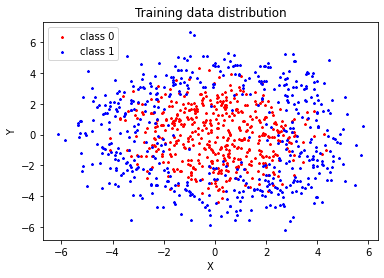

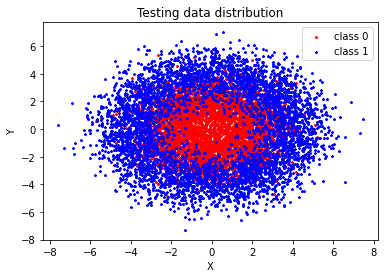

desired_hp:  [0.07108275 1.68621172]
Maximum Accuracy: 0.842


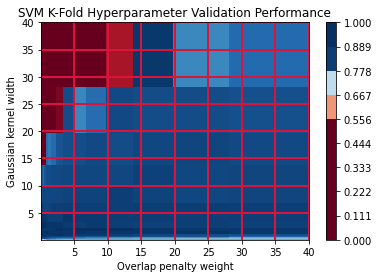

desired params:  [0.07108275 1.68621172]
num_samples:  1000  C:  0.07108274886025895  kernel_width:  1.6862117169591597  val_err:  0.17059999999999997  val_acc:  0.8294


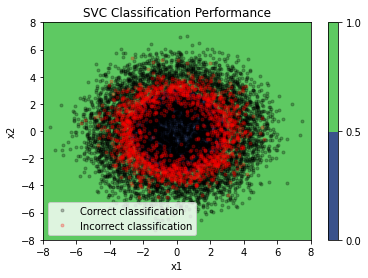

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, 

Desired Number of Perceptrons: 14


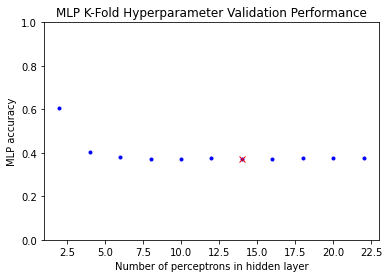

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model Summary:
Model: "sequential_1260"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2520 (Dense)          (100, 14)                 42        
                                                                 
 dense_2521 (Dense)          (100, 1)                  15        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
None
313/313 [==============================] - 1s 1ms/step - loss: 0.3838 - accuracy: 0.8302
num_samples:  1000  desired_num_perc:  14  val_err:  0.38379359245300293  val_acc:  0.8302000164985657


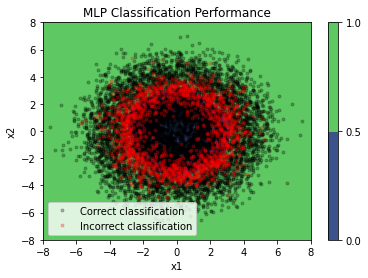

<Figure size 432x288 with 0 Axes>

In [30]:
if __name__ == "__main__":
    priors = [0.5, 0.5]
    label_ids = [0, 1]
    num_train_samples = 1000
    num_test_samples = 10000
    noise_mu = [0, 0]
    noise_sigma = np.eye(2, dtype=float)
    r = [2, 4]
    kfold = 10
    
    train_wt_cls = gen_data(num_train_samples, priors)
    plot_data(train_wt_cls, label_ids, 'Training')
    
    test_wt_cls = gen_data(num_test_samples, priors)
    plot_data(test_wt_cls, label_ids, 'Testing')
    
    train_kfoldSVC(train_wt_cls, test_wt_cls, kfold)
    train_kfoldMLP(train_wt_cls, test_wt_cls, kfold)


#Question-2

#### Helper Function

In [23]:
def train_val_split(data, idx, kfold):
    num_samples = data.shape[0]
    num_samples_batch = num_samples//kfold
    train_data = np.concatenate((data[0:idx*num_samples_batch],data[(idx+1)*num_samples_batch:]), axis=0)
    val_data = data[idx*num_samples_batch : (idx+1)*num_samples_batch]
    return train_data, val_data


def MOS(data, num_gmm_lst, kfold):
    num_samples = data.shape[0]
    gmm_mls = []
    for num_gmm in num_gmm_lst:
        max_likelihoods = []
        for val_idx in range(kfold):
            train_data, val_data = train_val_split(data, val_idx, kfold)
            GMM = GaussianMixture(num_gmm, covariance_type='full', random_state=0)
            GMM.fit(train_data)
            max_likelihood = GMM.score(val_data)
            num_val_samples = val_data.shape[0]
            max_likelihoods.append(num_val_samples * max_likelihood)

        mean_max_likelihoods = np.sum(max_likelihoods)/num_samples
        gmm_mls.append(mean_max_likelihoods)

    plt.title('GMM K-Fold Hyperparameters (Gaussian Components) Performance')
    plt.xlabel('No. of Gaussian Components')
    plt.ylabel('Average Max-log-likelihood Val')
    plt.scatter(num_gmm_lst, gmm_mls)
    plt.show()
    desired_num_gmm = num_gmm_lst[np.argmax(gmm_mls)]
    return desired_num_gmm,


def get_feature_vector(img): #Function to get important features in one go
    h, w = img.shape[:2]
    num_pixels = h * w
    feat_vec = np.zeros((num_pixels, 5), dtype='float')

    for row in range(h):
        for col in range(w):
            feat_vec[row*w + col, 0] = row
            feat_vec[row*w + col, 1] = col
            feat_vec[row*w + col, 2] = img[row, col, 2] #red
            feat_vec[row*w + col, 3] = img[row, col, 1] #green
            feat_vec[row*w + col, 4] = img[row, col, 0] #blue
    
    norm_feat_vec = normalize(feat_vec, axis=0, norm='max')
    return norm_feat_vec

####Main Function

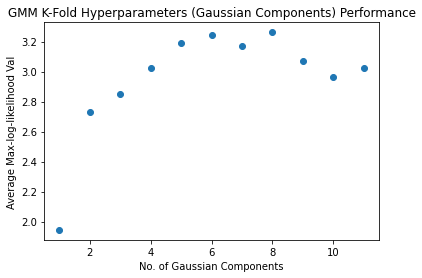

desired_num_gmm:  8


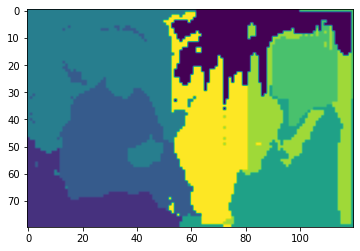

In [28]:
if __name__ == "__main__":
    img_path = '4.jpg'
    num_gmm_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    kfold = 10
    img = cv2.imread(img_path)
    norm_feat_vec = get_feature_vector(img)

    desired_num_gmm, = MOS(norm_feat_vec, num_gmm_lst, kfold)
    print('desired_num_gmm: ',desired_num_gmm)

    model = GaussianMixture(desired_num_gmm, covariance_type='full', random_state=0, init_params='kmeans', max_iter=100)
    model.fit(norm_feat_vec)

    prediction = np.zeros((norm_feat_vec.shape[0], desired_num_gmm))
    for i in range(desired_num_gmm):
        pdf = multivariate_normal.pdf(norm_feat_vec, mean=model.means_[i,:],cov=model.covariances_[i,:,:])
        prediction[:, i] = model.weights_[i] * pdf

    prediction = np.argmax(prediction, axis=1)
    prediction = prediction.reshape((img.shape[0], img.shape[1]))
    plt.imshow(prediction)
    plt.show()
